# Visualizing training behavior

In [1]:
using JLD2, LinearAlgebra, Makie, CairoMakie

include("../../MyTwoLayerNN/MyTwoLayerNN.jl")
include("../experimentplots.jl")

using .MyTwoLayerNN

Create the NN

In [16]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
m = 1_000
γ = 1.75    # w-lag (1.5, 0.25) lr=10, a-lag (1.5, -0.5) lr=1000
γ′ = 0.0

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = copy(nn)

# Training parameters
learning_rate = 1000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 1000.0, 100000000)

Create callback function

In [17]:
w_norms::Vector{Float64} = []
b_norms::Vector{Float64} = []
a_norms::Vector{Float64} = []

function mycallback(nn, step, loss)
    if step % 1000 == 1
        push!(w_norms, norm(nn.w))
        push!(b_norms, norm(nn.b))
        push!(a_norms, norm(nn.a))
    end
end

mycallback (generic function with 1 method)

Train the network

In [18]:
train!(nn, training_data; callback=mycallback)

Number of steps: 129444


Visualize size of w and a parameters during training

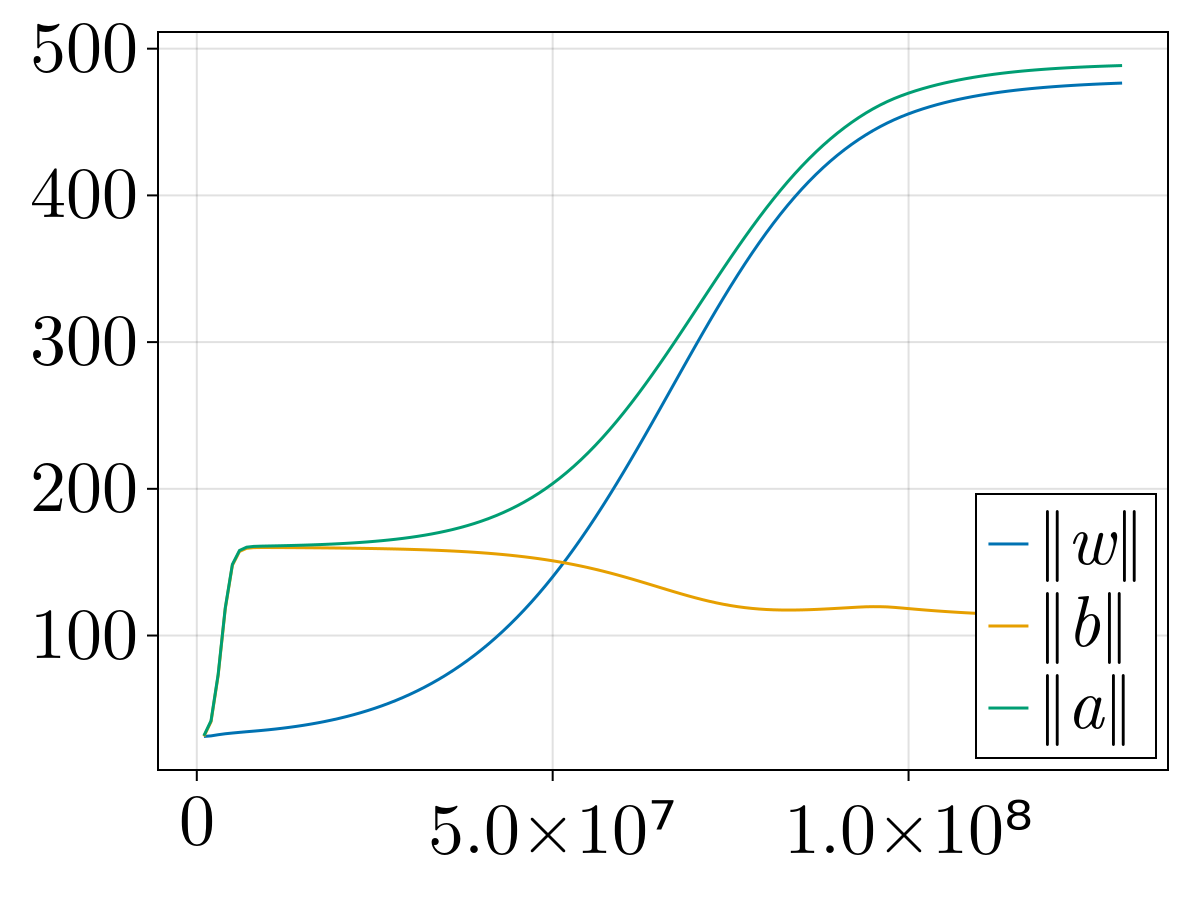

In [19]:
f = Figure()
ax = Axis(f[1, 1])

steps = 1000 * (1:length(w_norms)) * learning_rate

w_lines = lines!(ax, steps, w_norms)
b_lines = lines!(ax, steps, b_norms)
a_lines = lines!(ax, steps, a_norms)

axislegend(ax, [w_lines, b_lines, a_lines], [L"\Vert w\Vert", L"\Vert b\Vert", L"\Vert a\Vert"], position=:rb)

f

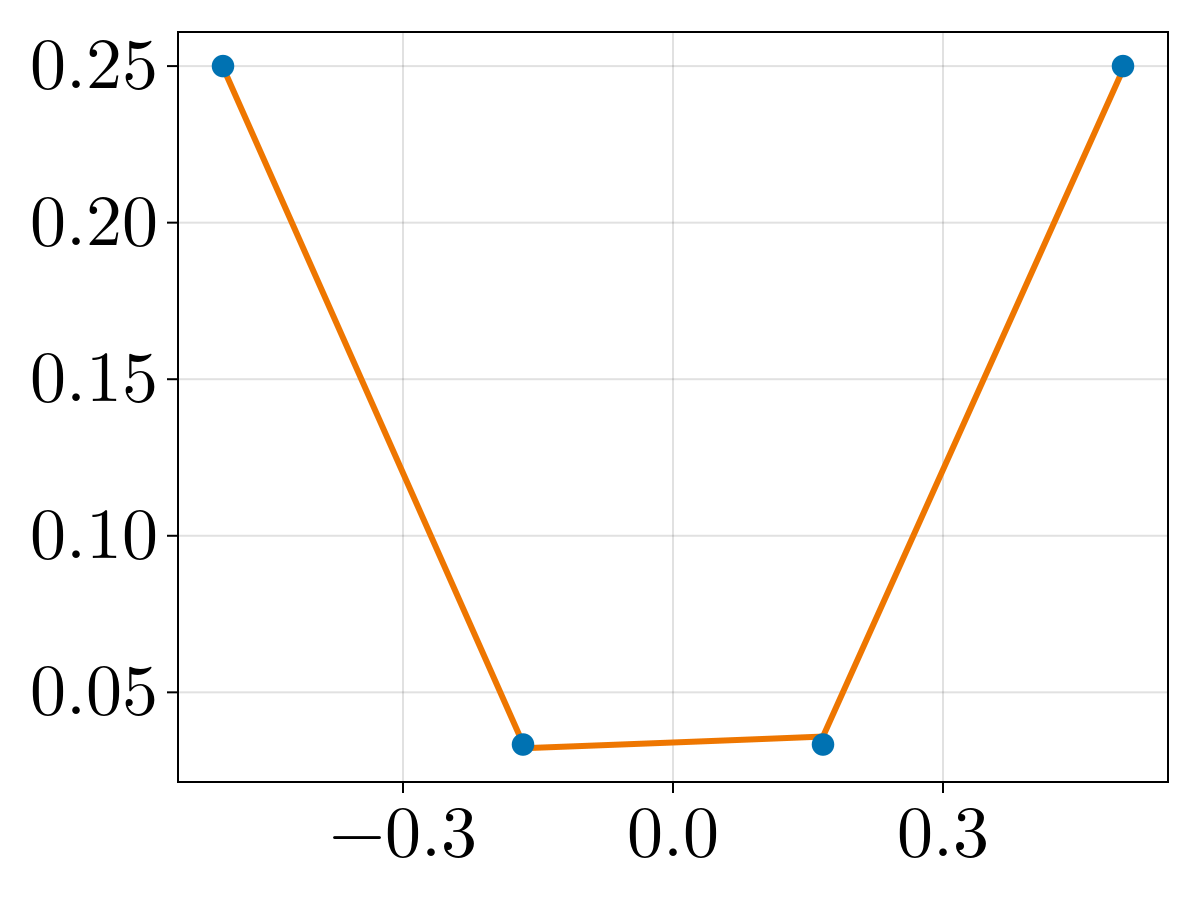

In [20]:
f = Figure()
ax = Axis(f[1, 1])

createlineplot!(ax, nn, training_data)

f

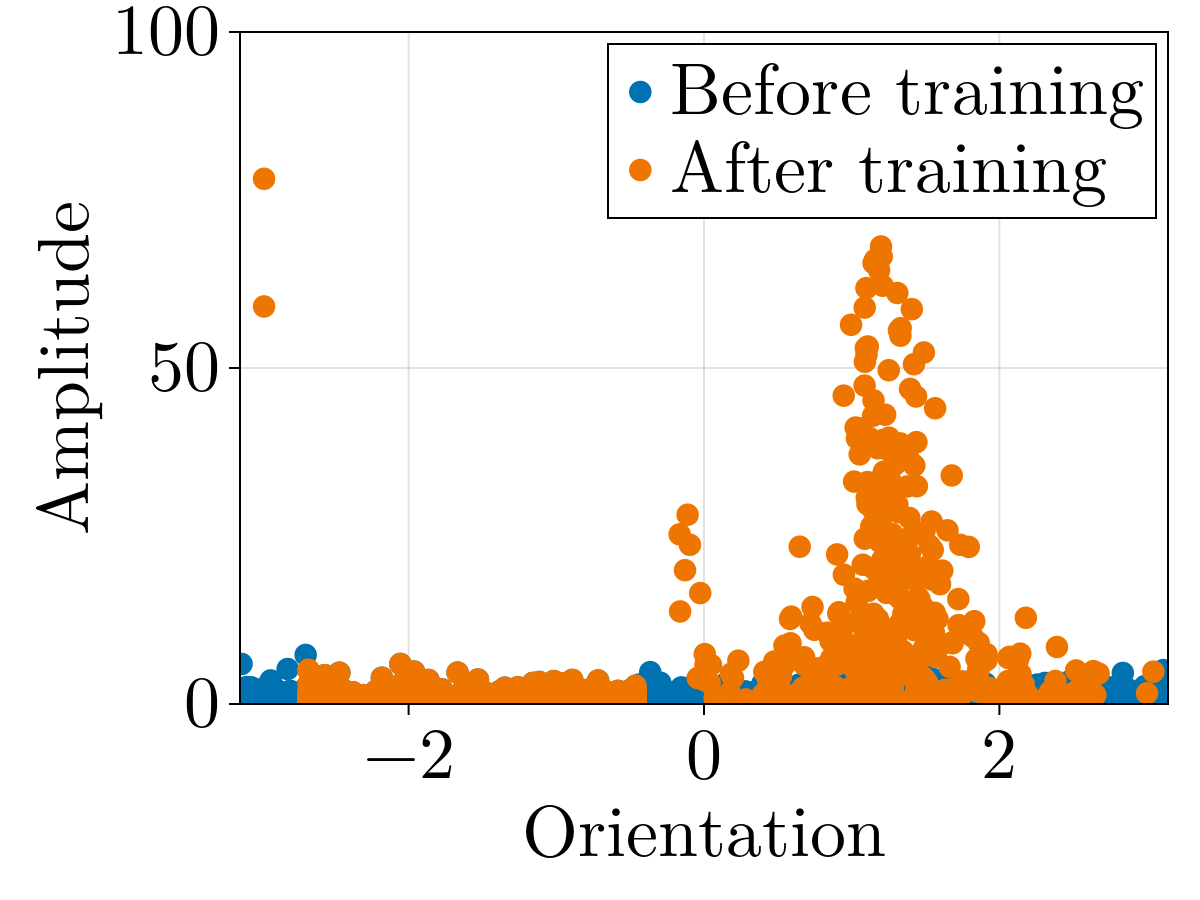

In [21]:
f = Figure()
ax = Axis(f[1, 1])

ylims!(ax, 0, 100)

createorientiationplot!(ax, initialNN, nn)

f

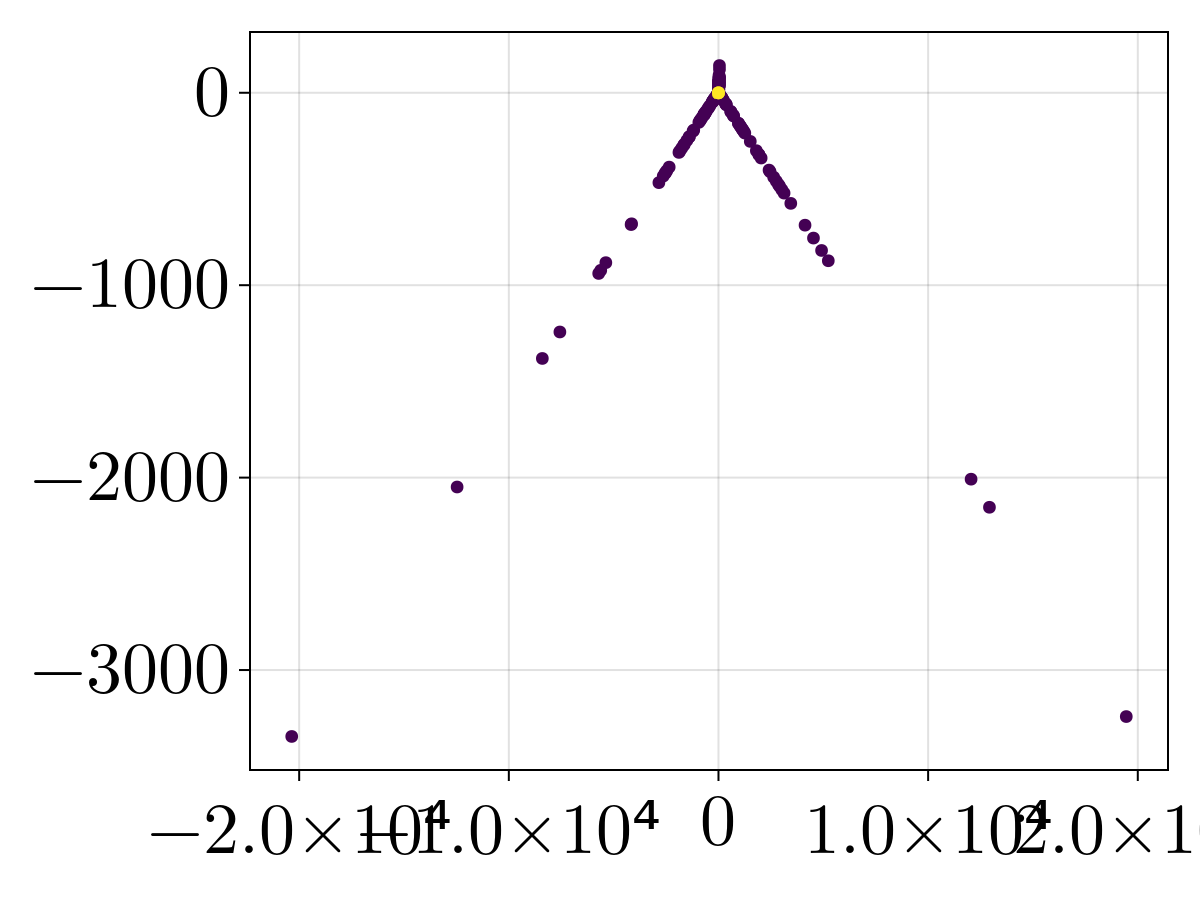

In [22]:
w_with_a = abs.(nn.a) .* vec(nn.w)
b_with_a = abs.(nn.a) .* nn.b
outputsigns = nn.a .|> signbit

f, ax, scat = scatter(w_with_a, b_with_a, color=outputsigns)

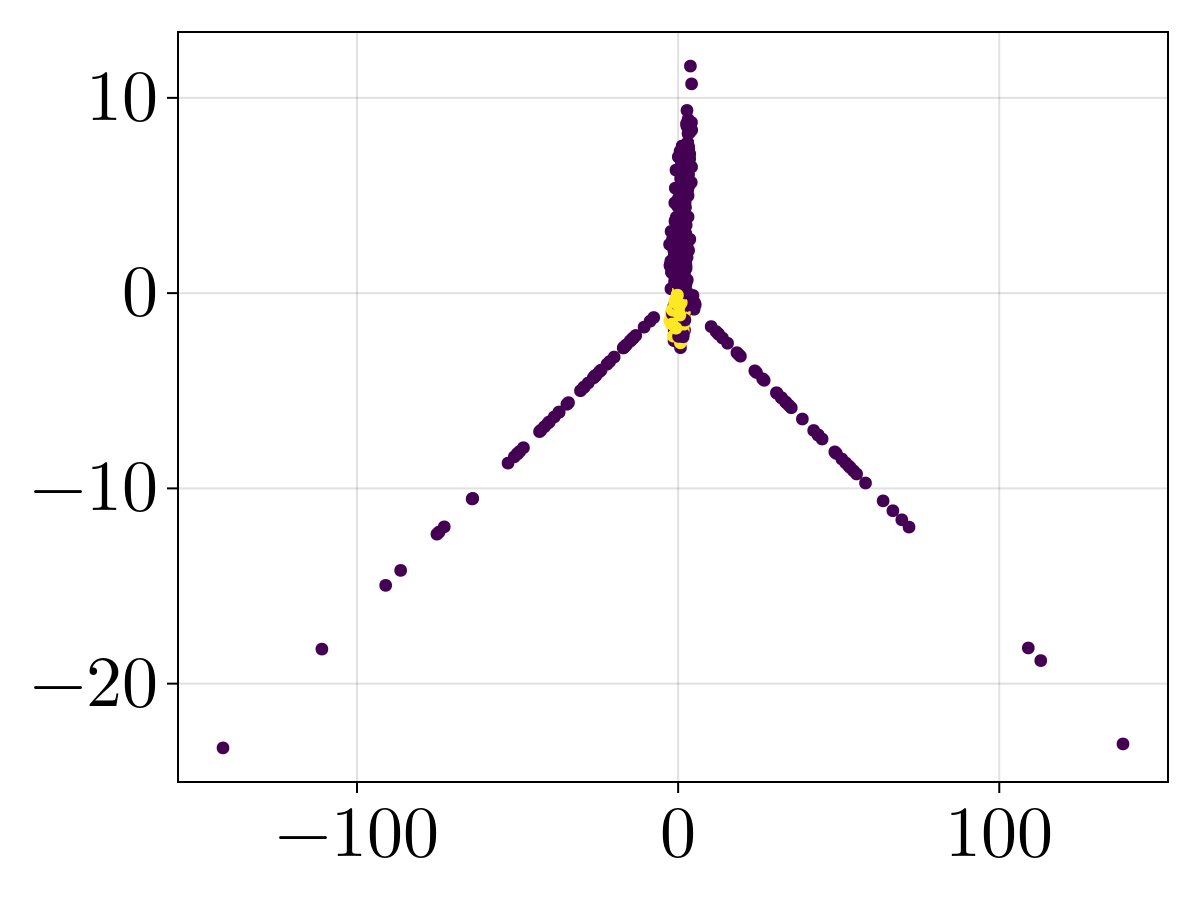

In [23]:
w_with_a = vec(nn.w)
b_with_a = nn.b
outputsigns = nn.a .|> signbit

f, ax, scat = scatter(w_with_a, b_with_a, color=outputsigns)

## Making movie

In [25]:
nn_for_vid = TwoLayerNN(d, 1000, 1.75, 0.0)

wobs = Observable(zero(abs.(nn_for_vid.a) .* vec(nn_for_vid.w)))
bobs = Observable(zero(abs.(nn_for_vid.a) .* nn_for_vid.b))
cobs = Observable(signbit.(nn_for_vid.a))
time = Observable(0.0)

# Create initial plot
fig, ax, scat = scatter(wobs, bobs, color = cobs, axis = (title = @lift("t = $(round($time, digits=1))"),))

xlims!(ax, -21_000, 21_000); ylims!(ax, -3600, 1000) # Wide view 
# xlims!(ax, -200, 200); ylims!(ax, -100, 600) # Mid view 
# xlims!(ax, -5, 5); ylims!(ax, -8, 20) # Close view
# xlims!(ax, -1, 1); ylims!(ax, -2, 2) # Tiny view

# Movie parameters
max_steps_vid = 1000
framerate = 13
timestamps = range(0, 10, step=1/framerate)

# max_steps_vid = 80
# framerate = 20
# timestamps = range(0, 10, step=1/framerate)

# Training data 
learning_rate_vid = 1000.0
training_data_vid = TrainingData(dataX, dataY, learning_rate_vid, max_steps_vid)

# Create video
record(fig, "wide parameters over time.mp4", timestamps; framerate = framerate) do t
    # Train NN from t > 0
    !iszero(t) && train!(nn_for_vid, training_data_vid)

    # Update scatter plot data
    wobs[] = abs.(nn_for_vid.a) .* vec(nn_for_vid.w)
    bobs[] = abs.(nn_for_vid.a) .* nn_for_vid.b
    cobs[] = signbit.(nn_for_vid.a)
    time[] = t * framerate * max_steps_vid * learning_rate_vid

    # autolimits!(ax)
end

"tiny parameters over time.mp4"

In [40]:
nn_for_vid = TwoLayerNN(d, 1000, 1.75, 0.0)

xmin, xmax = dataX |> Iterators.flatten |> extrema
xvals = range(xmin, xmax, length=100)

# Scatter plot observables 
wobs = Observable(zero(abs.(nn_for_vid.a) .* vec(nn_for_vid.w)))
bobs = Observable(zero(abs.(nn_for_vid.a) .* nn_for_vid.b))
cobs = Observable(signbit.(nn_for_vid.a))

# Line plot observables
yobs = Observable([forward(nn_for_vid, p) for p in xvals])
iobs = Observable(-nn.b ./ vec(nn.w))
iyobs = Observable([forward(nn_for_vid, p) for p in iobs[]])

# General observables
time = Observable(0.0)

# Create initial scatter plot
fig, ax, scat = scatter(wobs, bobs, color = cobs, figure=(size=(1000, 1500),))
xlims!(ax, -21_000, 21_000); ylims!(ax, -3600, 1000)

# Create initial line plot
ax2 = Axis(fig[2, 1])
lines!(ax2, xvals, yobs, color=:darkorange2)
scatter!(ax2, vcat(dataX...), dataY)
scatter!(ax2, iobs, iyobs, marker=:star5, color=:darkgreen)
xlims!(ax2, -0.55, 0.55)

# Movie parameters
max_steps_vid = 1000
framerate = 13
timestamps = range(0, 10, step=1/framerate)

# Training data 
learning_rate_vid = 1000.0
training_data_vid = TrainingData(dataX, dataY, learning_rate_vid, max_steps_vid)

# Create video
record(fig, "test.mp4", timestamps; framerate = framerate) do t
    # Train NN from t > 0
    !iszero(t) && train!(nn_for_vid, training_data_vid)

    # Update scatter plot data
    wobs[] = abs.(nn_for_vid.a) .* vec(nn_for_vid.w)
    bobs[] = abs.(nn_for_vid.a) .* nn_for_vid.b
    cobs[] = signbit.(nn_for_vid.a)

    # Update line plot data
    yobs[] = [forward(nn_for_vid, p) for p in xvals]
    iobs[] = -nn_for_vid.b ./ vec(nn_for_vid.w)
    iyobs[] = [forward(nn_for_vid, p) for p in iobs[]]

    # Update title
    time[] = t * framerate * max_steps_vid * learning_rate_vid
end

Number of steps: 444


"test.mp4"

## Orientation over time

In [86]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
m = 1_000
γ = 1.75
γ′ = 0.0

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = copy(nn)

# Training parameters
learning_rate = 1000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 1000.0, 100000000)

In [87]:
orientations = angle.(vec(nn.w) + im * nn.b)

function callback_ovt(nn, step, loss)
    if step % 1000 == 1
        global orientations=cat(orientations, angle.(vec(nn.w) + im * nn.b); dims=2)
    end
end

callback_ovt (generic function with 1 method)

In [88]:
train!(nn, training_data; callback=callback_ovt)

Number of steps: 129444


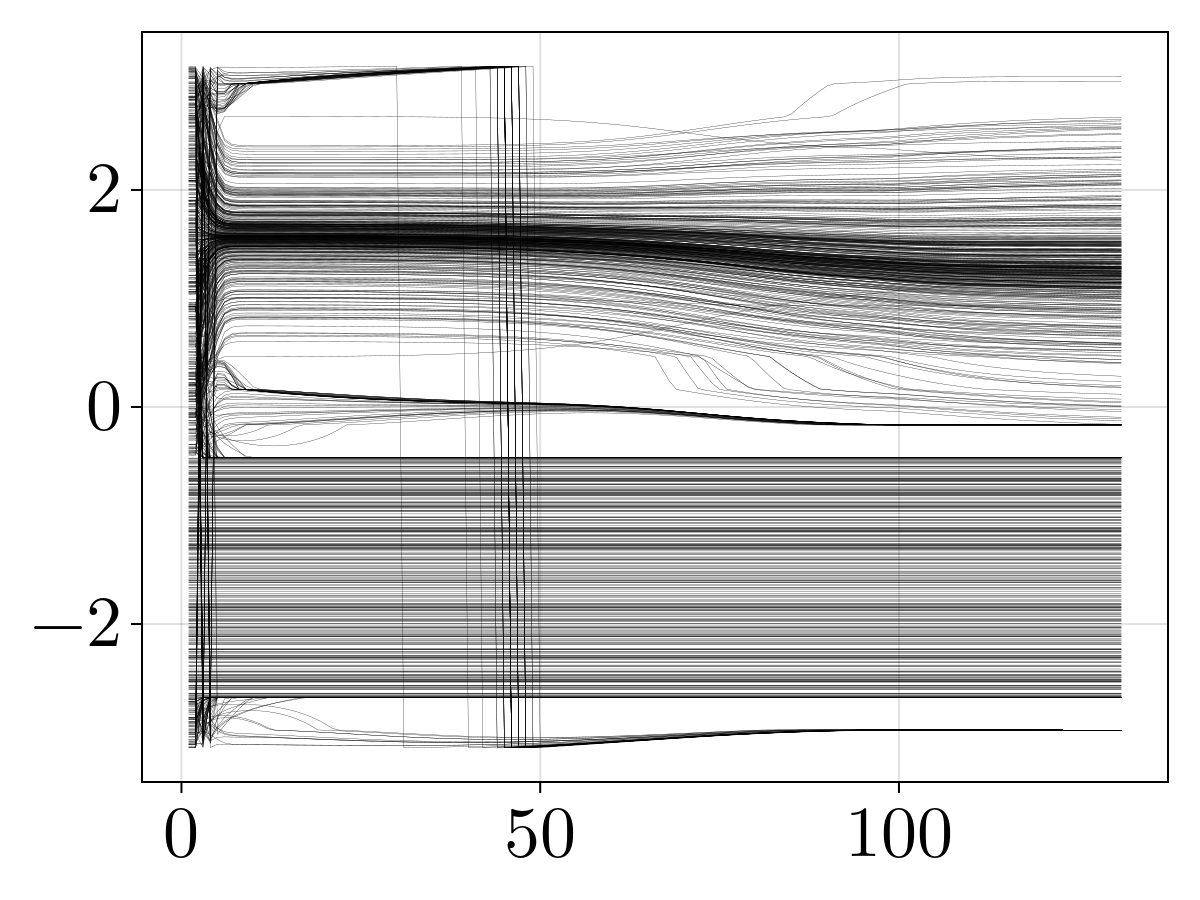

In [90]:
series(orientations; solid_color=:black, linewidth=0.15)